### Urban Air Quality in Motion: Unraveling Traffic's Effect on Berlin's Air Quality in 2023

**Georgios Kaisaris**  
**07.01.2024**

### Contents :  
1. Introduction
2. Data Source
3. Loading Data
4. Answering broad questions  
    * Question 1 
    * Question 2 
5. Conclusion
6. Outlook

### Introduction

The declining quality of air in modern cities is an important problem that needs to be adressed. The project is motivated by the critical need to understand and mitigate the adverse health effects of air pollution in urban centers, especially those linked to vehicular emissions. The results can give insights into the specific impact of traffic on air quality. This way we can provide local authorities and environmental organizations with data-driven insights for the implementation of measures aimed at reducing pollution and improving the quality of life for Berlin's residents.  
This report will attempt to answer the following questions:  
* Are there easily identifiable patterns in traffic and air quality data?
* How Does Traffic Volume Relate to Air Quality?

### Datasource

Datasource1: Verkehrsdetektion Berlin 
* Metadata URL: https://mobilithek.info/offers/-8644654323912256067
* Data URL: https://api.viz.berlin.de/daten/verkehrsdetektion?path=2023%2FMessquerschnitte+%28fahrtrichtungsbezogen%29%2F
* Data Type: CSV

The data from the Berlin traffic detection system is provided on a monthly basis as hourly values from the lane-accurate traffic detectors. 

Datasource2: Luftgütemessdaten
* Metadata URL: https://www.govdata.de/web/guest/suchen/-/details/luftgutemessdaten
* Data URL: https://luftdaten.berlin.de/pollution/pm10?stationgroup=all&period=1h&timespan=lastweek
* Data Type: CSV

This dataset includes information relevant to air pollutants with respect to the 39th BImSchV and is crucial for assessing air quality in Berlin. It encompasses gaseous air pollutants (nitrogen oxides, ozone, carbon monoxide, benzene, toluene, and sulfur dioxide) as well as particulate air pollutants (PM10 and PM2.5).


### Data Tranformation

The complete data transformation process occurs within the project/pipeline.py file. In this file, the specified datasources are retrieved from the internet, undergo cleaning, merging, and are subsequently stored in an sqlite database.

The resultant database comprises two tables: "traffic" and "airQuality".
* traffic: Includes data about the volume of traffic and the average speed of the cars that passed through each measuring station in Berlin. The data from the Berlin traffic detection system is provided on a monthly basis as hourly values from the lane-accurate traffic detectors. 

* airQuality: This table includes information relevant to air pollutants. Particulate Matter (PM) refers to tiny particles or droplets in the air that can be inhaled into the lungs. PM is categorized based on the size of the particles, with PM10 and PM2.5 referring to particles with aerodynamic diameters of 10 micrometers and 2.5 micrometers or smaller, respectively. On the other hand, NO, NO2 and O3 refers to gaseous air pollutants.

### Loading Data

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
wdir = os.path.dirname(os.getcwd())
relative_path = 'data\\UrbanAirQualityInMotion.sqlite'
wdir = os.path.join(wdir, relative_path)

con = sqlite3.connect(wdir)

Looking at the data

In [3]:
query = "SELECT * FROM traffic"
df_traffic = pd.read_sql(query, con)

df_traffic.head()

,mq_name,tag,stunde,qualitaet,q_kfz_mq_hr,v_kfz_mq_hr,q_pkw_mq_hr,v_pkw_mq_hr,q_lkw_mq_hr,v_lkw_mq_hr
0,TE001,02.01.2023,13,1.0,2134,83,2037,83,97,71
1,TE001,02.01.2023,14,1.0,2349,67,2299,67,50,60
2,TE001,02.01.2023,15,1.0,2325,62,2288,62,37,63
3,TE001,02.01.2023,16,1.0,1846,65,1752,64,94,74
4,TE001,02.01.2023,17,1.0,1276,73,1179,73,97,76


In [4]:
query = "SELECT * FROM airQuality"
df_airQuality = pd.read_sql(query, con)
con.close()

df_airQuality.head()

,datetime,PM10,PM2.5,NO2,NO,NOx,O3,station
0,01.01.2023 01:00,77.0,60.0,19.0,5.0,27.0,38.0,mc010
1,01.01.2023 02:00,31.0,22.0,9.0,2.0,11.0,50.0,mc010
2,01.01.2023 03:00,19.0,11.0,5.0,2.0,7.0,54.0,mc010
3,01.01.2023 04:00,22.0,13.0,6.0,2.0,8.0,54.0,mc010
4,01.01.2023 05:00,18.0,11.0,6.0,2.0,8.0,53.0,mc010


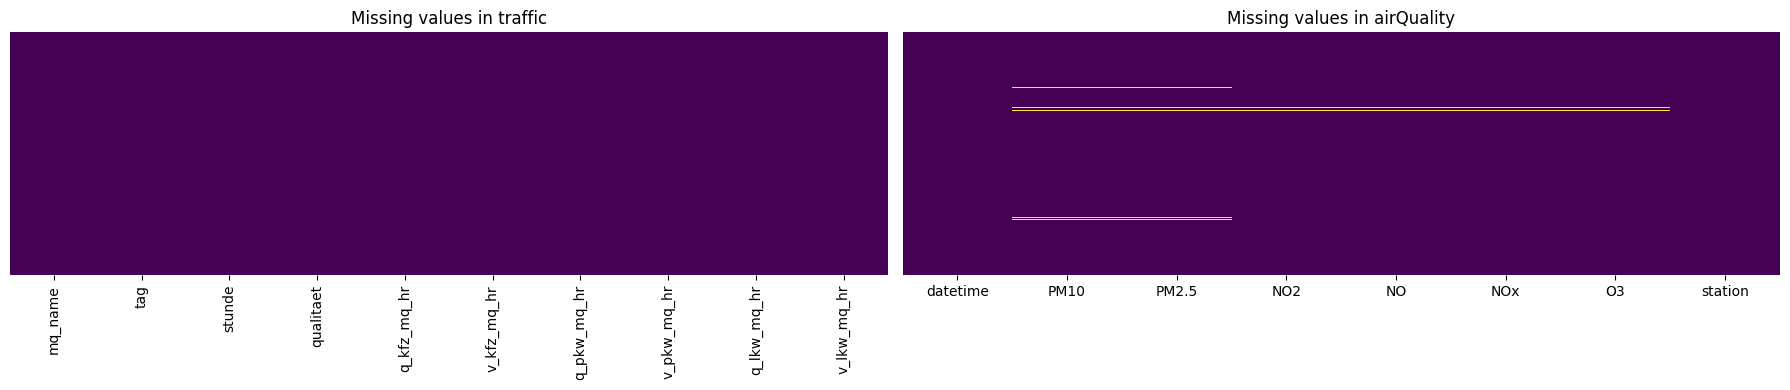

In [5]:
#Let's check for missing values in our dataset

fig, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.heatmap(df_traffic.isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[0])
axes[0].set_title('Missing values in traffic')

sns.heatmap(df_airQuality.isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[1])
axes[1].set_title('Missing values in airQuality')

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

We can see that airquality has some missing values. There are 2 ways to deal with rows that have missing values:  
1. Deletion  
2. Imputation

Since the data is continuous it makes sense to fill the missing rows with the data from the previous hour

In [6]:
df_airQuality = df_airQuality.ffill() #Fills missing values

### Answering Questions

Question1: Are there easily identifiable patterns in traffic and air quality data?

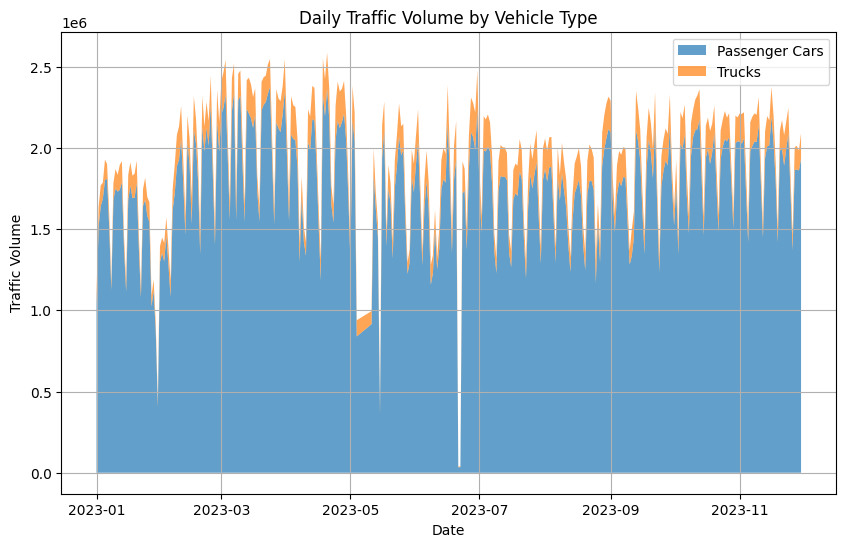

In [7]:
df_traffic['tag'] = pd.to_datetime(df_traffic['tag'], format='%d.%m.%Y')
traffic_by_day = df_traffic[['tag', 'q_kfz_mq_hr', 'q_pkw_mq_hr', 'q_lkw_mq_hr']].groupby(by = ["tag"], as_index=False).sum()

plt.figure(figsize=(10, 6))
plt.fill_between(traffic_by_day['tag'], 0, traffic_by_day['q_pkw_mq_hr'], label='Passenger Cars', alpha=0.7)
plt.fill_between(traffic_by_day['tag'], traffic_by_day['q_pkw_mq_hr'], traffic_by_day['q_kfz_mq_hr'], label='Trucks', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.title('Daily Traffic Volume by Vehicle Type')
plt.legend()
plt.grid(True)
plt.show()

In this first graph we see that vehicle traffic stays about the same throughout the year in Berlin, with Passenger cars being by far the most. There is an empty space in this graph. I have checked the data source and there seems to be no data available between the 5th and 10th of May

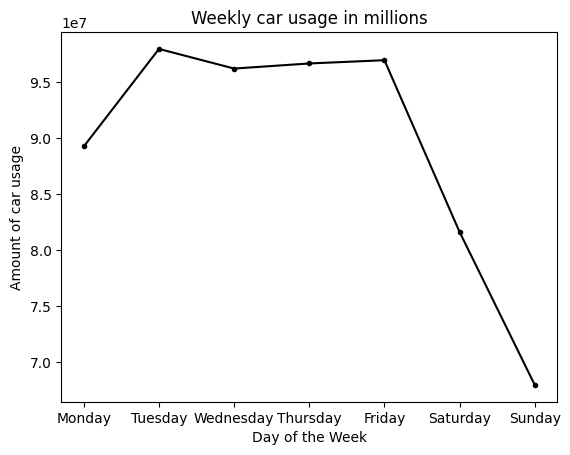

In [8]:
def get_weekday(ts):
    return ts.weekday()

traffic_by_day["Weekday"] = traffic_by_day["tag"].apply(lambda x: get_weekday(x))

plt.plot(np.sort(traffic_by_day["Weekday"].unique()), traffic_by_day.groupby(["Weekday"])["q_kfz_mq_hr"].sum(), 'k.-')

plt.xticks(ticks= [0,1,2,3,4,5,6],labels = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.xlabel("Day of the Week")
plt.ylabel("Amount of car usage")
plt.title("Weekly car usage in millions")
plt.show()

As expected we see the amount of cars in the streets fall during weekends.


More specifically, to get a quick understanding of the periodic patterns of the data, let us have a look at the demand per hour during a week.

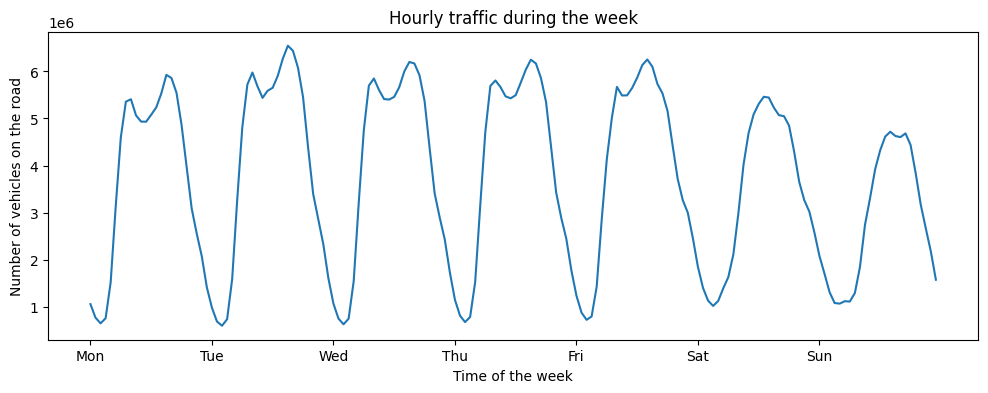

In [9]:
grouped_df = df_traffic.groupby(by=["tag", "stunde"], as_index=False)[['q_kfz_mq_hr']].sum()
grouped_df["weekday"] = grouped_df["tag"].apply(lambda x: get_weekday(x))

fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = grouped_df.groupby(["weekday", "stunde"])['q_kfz_mq_hr'].sum()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Hourly traffic during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat","Sun"],
    xlabel="Time of the week",
    ylabel="Number of vehicles on the road",
)

Again as expected we see that the number of vehicles is low at the beginning of the day, but has a peak in the morning and then another one in the afternoon before it goes down again in the night.

##### Now let's do the same graphs for airquality levels and see if there are any similarities.

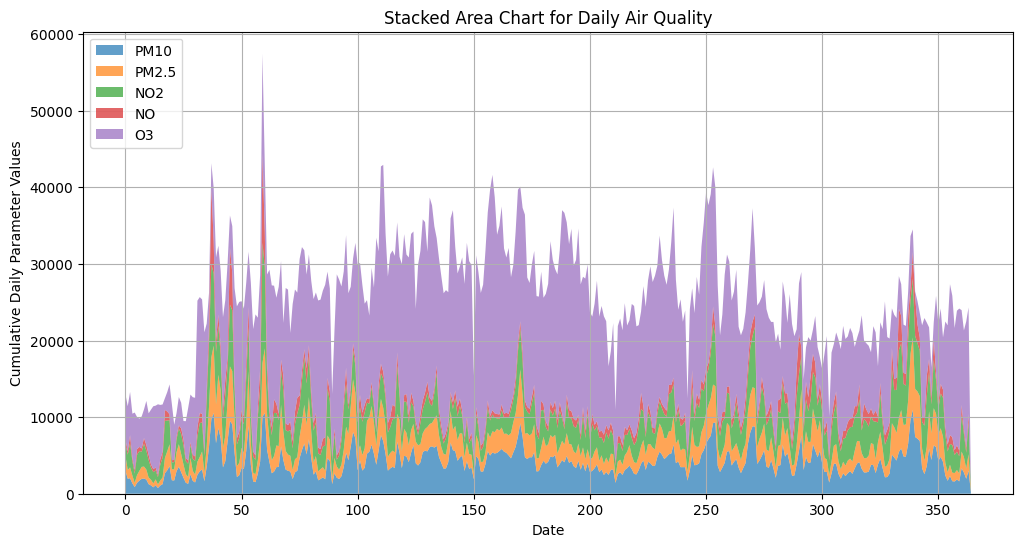

In [10]:
parameters = ['PM10', 'PM2.5', 'NO2', 'NO', 'O3']

df_airQuality['datetime'] = pd.to_datetime(df_airQuality['datetime'], format='%d.%m.%Y %H:%M')

# Parameters in your DataFrame
df_airdaily = df_airQuality.groupby(df_airQuality['datetime'].dt.date)[parameters].sum().reset_index()
# Plot stacked area chart for daily values
plt.figure(figsize=(12, 6))
plt.stackplot(df_airdaily.index, df_airdaily[parameters].T, labels=parameters, alpha=0.7)

# Customize the plot
plt.title('Stacked Area Chart for Daily Air Quality')
plt.xlabel('Date')
plt.ylabel('Cumulative Daily Parameter Values')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Emissions also seem to stay abßout the same throughout the year with exceptions the beginning and the end of it.

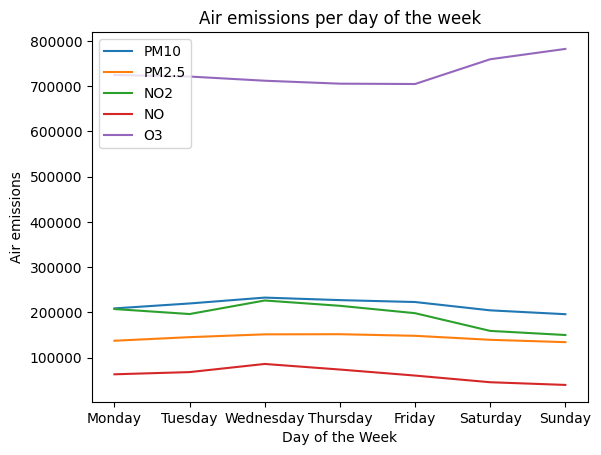

In [11]:
df_airdaily["Weekday"] = df_airdaily["datetime"].apply(lambda x: get_weekday(x))

plt.plot(np.sort(df_airdaily["Weekday"].unique()), df_airdaily.groupby(["Weekday"])[['PM10', 'PM2.5', 'NO2', 'NO', 'O3']].sum(), label=['PM10', 'PM2.5', 'NO2', 'NO', 'O3'])

plt.xticks(ticks= [0,1,2,3,4,5,6],labels = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.xlabel("Day of the Week")
plt.ylabel("Air emissions")
plt.title("Air emissions per day of the week")
plt.legend(loc='upper left')
plt.show()

As we can see for PM10, NO2 and NO the emissions seem to decrease in the weekend together with the decrease of traffic. Meanwhile the O3 emissions actually increase and the emissions for PM2.5 stay the same. We will see if there is actually a correlation when we answer our second question.

Question2: How Does Traffic Volume Relate to Air Quality?

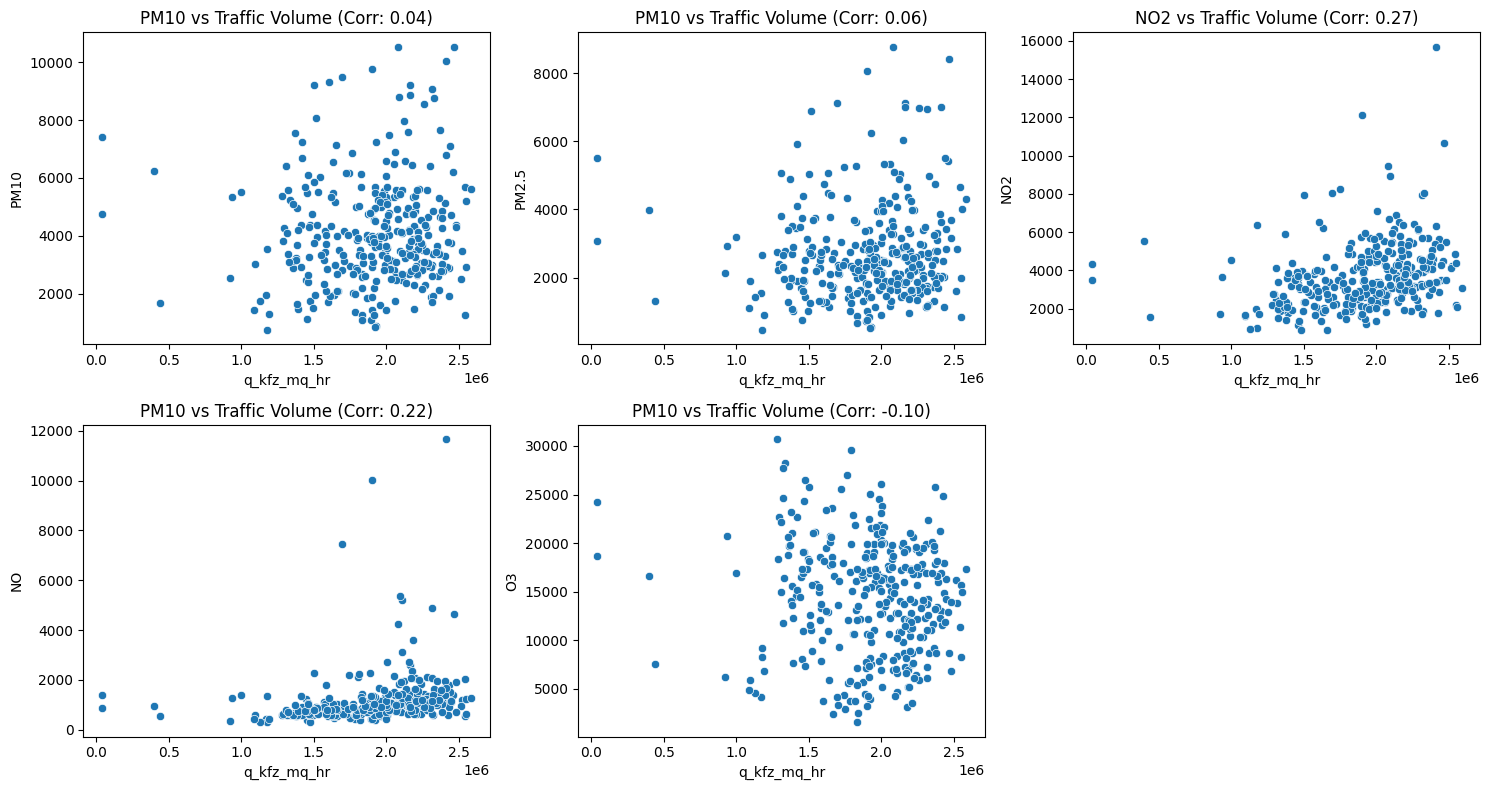

In [12]:
df_airdaily['datetime'] = pd.to_datetime(df_airdaily['datetime'])
result_df = pd.merge(df_airdaily, traffic_by_day, left_on='datetime', right_on='tag', how='left')

# Calculate correlation coefficients
correlation_PM10 = result_df['q_kfz_mq_hr'].corr(result_df['PM10'])
correlation_PM25 = result_df['q_kfz_mq_hr'].corr(result_df['PM2.5'])
correlation_NO = result_df['q_kfz_mq_hr'].corr(result_df['NO'])
correlation_NO2 = result_df['q_kfz_mq_hr'].corr(result_df['NO2'])
correlation_O3 = result_df['q_kfz_mq_hr'].corr(result_df['O3'])

# Scatter plot of traffic volume vs air quality parameters
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.scatterplot(x='q_kfz_mq_hr', y='PM10', data=result_df)
plt.title(f'PM10 vs Traffic Volume (Corr: {correlation_PM10:.2f})')

plt.subplot(2, 3, 2)
sns.scatterplot(x='q_kfz_mq_hr', y='PM2.5', data=result_df)
plt.title(f'PM10 vs Traffic Volume (Corr: {correlation_PM25:.2f})')

plt.subplot(2, 3, 3)
sns.scatterplot(x='q_kfz_mq_hr', y='NO2', data=result_df)
plt.title(f'NO2 vs Traffic Volume (Corr: {correlation_NO2:.2f})')

plt.subplot(2, 3, 4)
sns.scatterplot(x='q_kfz_mq_hr', y='NO', data=result_df)
plt.title(f'PM10 vs Traffic Volume (Corr: {correlation_NO:.2f})')

plt.subplot(2, 3, 5)
sns.scatterplot(x='q_kfz_mq_hr', y='O3', data=result_df)
plt.title(f'PM10 vs Traffic Volume (Corr: {correlation_O3:.2f})')

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()


From what we see only NO and NO2 are slightly correlated with the increase in traffic.

Both PM10 and PM2.5 can be emitted from various sources, and while vehicles, including cars, are contributors, they are not the sole cause. Other sources of PM emissions include industrial processes, construction activities, agriculture (such as plowing fields), residential heating (burning wood or other fuels), and natural sources like wildfires and dust storms.

On the other hand, NO (nitric oxide) and NO2 (nitrogen dioxide) emissions are mainly produced by vehicles, particularly internal combustion engines in cars. These pollutants are part of nitrogen oxide (NOx) emissions, which result from the combustion of fossil fuels, such as gasoline and diesel, in engines. 

Ozone (O3) emissions can be influenced by various sources, and while cars contribute to the formation of ozone, they are not the sole cause. Ozone is a secondary pollutant, meaning it is not directly emitted into the air but forms through complex chemical reactions involving precursor pollutants.

Another way to visualize our results is with a correlation matrix.

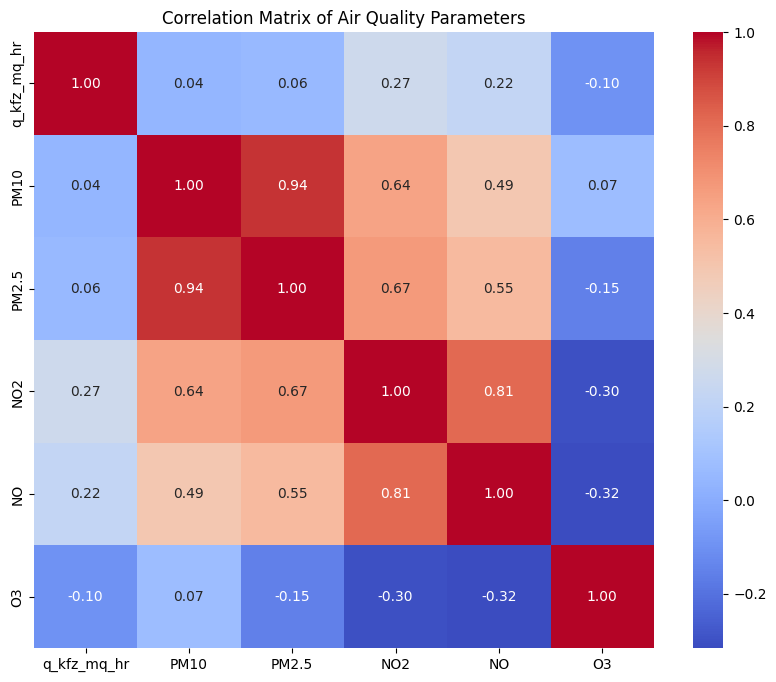

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(result_df[['q_kfz_mq_hr','PM10', 'PM2.5', 'NO2', 'NO', 'O3']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Air Quality Parameters')
plt.show()

### Conclusion:


In conclusion we tried to answer the following mentioned questions :

    1. Are there easily identifiable patterns in traffic and air quality data in Berlin?

In the first section we saw that traffic volumes as expected decrease during the weekends and in the night they fall drastically. We saw that for PM10, NO and NO2 this trend also exists and were wondering if there is any actual correlation between these two parameters. Therefore, in the second part we examined the correlation and discovered that, indeed for NO and NO2 there seems to be a slight correlation between the traffic volume and emissions in Berlin.

    2. How Does Traffic Volume Relate to Air Quality?
    
Only for NO and NO2 emissions there seems to be a slight correlation with traffic volume. There are mutliple sources of emissions in a big city like Berlin so the relatively small change in traffic from day to day might not be one of the biggest factors of day to day emissions in the city.

We have to account for the fact that the data available is only for the year 2023 and the city of Berlin. Consequently, any conclusions drawn should be limited to that particular city and time frame. Additionally, considering the complex nature of emissions, it's important to recognize the presence of multiple variables that need consideration. Therefore, it needs to be emphasized that correlation does not equal causation.

Understanding the impact of various factors on our mobility choices is crucial, as it enables us to guide our future towards a more environmentally friendly and sustainable path.
